In [1]:
%load_ext autoreload
%autoreload 2
import copy

import cv2
import matplotlib.pyplot as plt
import numpy as np

import pipeline

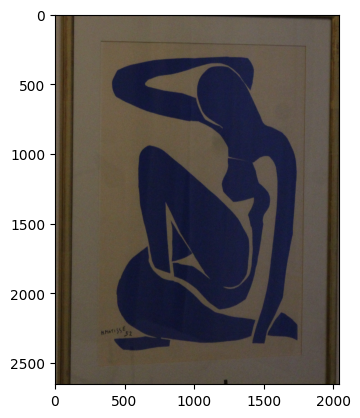

In [2]:
# original_img = cv2.imread('../resources/craiyon_161334_Fabrication_and_Prototyping_in_the_LearningLab.png')
original = cv2.imread('../resources/portrait.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.imshow(original)

In [3]:
# img = pipeline.grayscale(original)['img']
# img = pipeline.blur(img, **{'method': 'gaussian', 'kernel': 11, 'sigma': 0})['img']
# img = pipeline.edge_detect(img, **{'min': 50, 'max': 125})['img']
# img = pipeline.dilate(img, **{'kernel': 10, 'iterations': 1})['img']
# img = pipeline.erode(img, **{'kernel': 5, 'iterations': 1})['img']
# img = pipeline.threshold(img, **{'method': 'mean', 'c': 0, 'block_size': 11})['img']
# fine = pipeline.find_contours(img, **{'method': 'simple'})['contours']
#
# fig = plt.figure(figsize=(15, 10))
# fig.add_subplot(1, 2, 1)
# plt.title('Pipelined Image')
# plt.imshow(img, cmap='gray')
#
# contour_img = original.copy()
# cv2.drawContours(contour_img, fine, -1, (0, 255, 0))
#
# fig.add_subplot(1, 2, 2)
# plt.title(f'Contours (len={pipeline.contour_len(fine)})')
# plt.imshow(contour_img, cmap='gray')

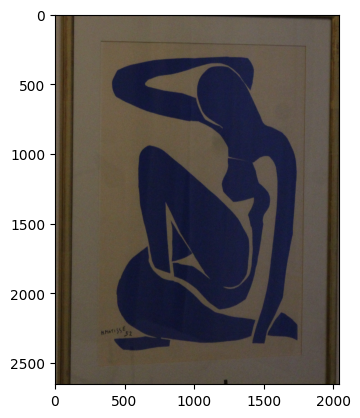

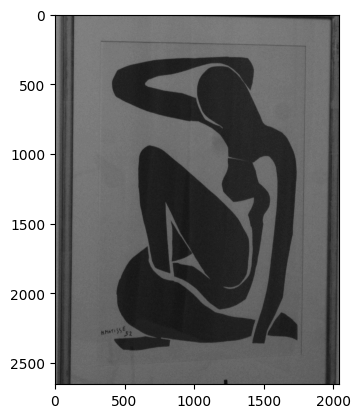

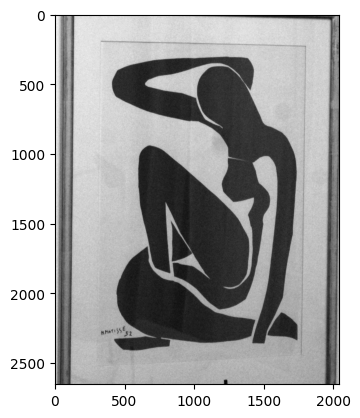

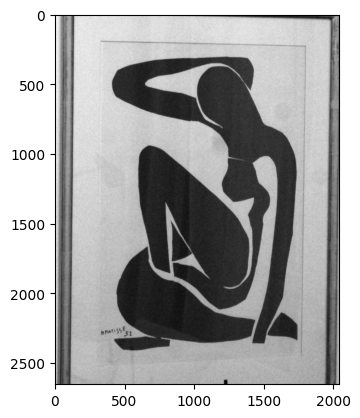

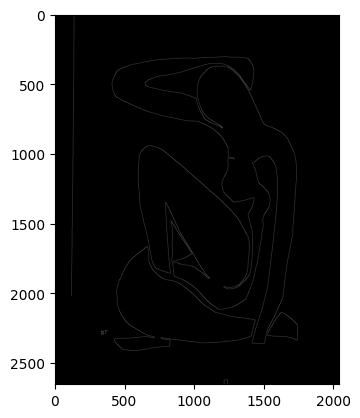

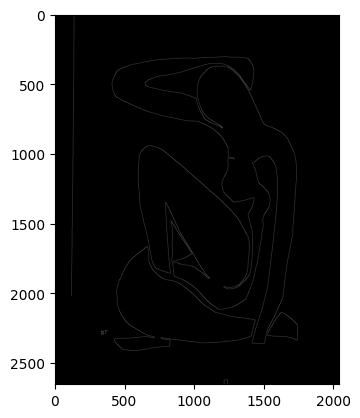

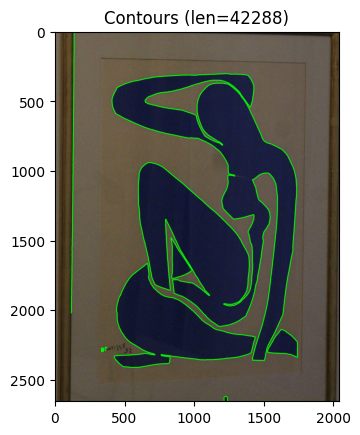

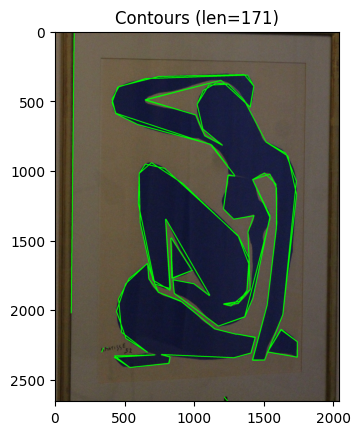

In [10]:
# pl, contours, hierarchy = pipeline.Pipeline(original) \
#     .grayscale() \
#     .median_blur(5) \
#     .gaussian_blur((5, 5), 0) \
#     .canny_edge_detect(50, 125) \
#     .dilate(np.ones((10, 10), np.uint8), 1) \
#     .erode(np.ones((5, 5), np.uint8), 1) \
#     .threshold(50, 125) \
#     .find_contours()

fig = plt.figure()
plt.imshow(original)

img = pipeline.grayscale(original)['img']
fig = plt.figure()
plt.imshow(img, cmap='gray')

img = pipeline.blur(img, **{'method': 'median', 'kernel': 5})['img']
fig = plt.figure()
plt.imshow(img, cmap='gray')

img = pipeline.blur(img, **{'method': 'gaussian', 'kernel': 5, 'sigma': 0})['img']
fig = plt.figure()
plt.imshow(img, cmap='gray')

img = pipeline.edge_detect(img, **{'min': 50, 'max': 125})['img']
fig = plt.figure()
plt.imshow(img, cmap='gray')

# img = pipeline.dilate(img, **{'kernel': 10, 'iterations': 1})['img']
# fig = plt.figure()
# plt.imshow(img, cmap='gray')
#
# img = pipeline.erode(img, **{'kernel': 5, 'iterations': 1})['img']
# fig = plt.figure()
# plt.imshow(img, cmap='gray')

img = pipeline.threshold(img, **{'method': 'otsu'})['img']
fig = plt.figure()
plt.imshow(img, cmap='gray')

fine = pipeline.find_contours(img, **{'method': 'simple'})
contour_img = original.copy()
cv2.drawContours(contour_img, fine['contours'], -1, (0, 255, 0), 5)
fig = plt.figure()
plt.title(f'Contours (len={fine["length"]})')
plt.imshow(contour_img, cmap='gray')

smooth = pipeline.smooth_contours(**{'contours': fine['contours'], 'accuracy': 30})
smooth_contour_img = original.copy()
cv2.drawContours(smooth_contour_img, smooth['contours'], -1, (0, 255, 0), 5)
fig = plt.figure()
plt.title(f'Contours (len={smooth["length"]})')
plt.imshow(smooth_contour_img, cmap='gray')

# print(smooth['contours'])
svg = pipeline.contours2svg(smooth['contours'])
with open('./img.svg', 'w') as f:
    f.write(svg)



# contour_img = pl.rgb()
# cv2.drawContours(contour_img.img, contours, -1, (0, 255, 0), 3)
# fig.add_subplot(1, 3, 2)
# plt.title(f'Contours (len={pipeline.contour_len(contours)})')
# plt.imshow(contour_img.img, cmap='gray')
#
# smooth_contours = pipeline.smooth_contours(copy.deepcopy(contours), 5)
# smooth_contour_img = pl.rgb()
# cv2.drawContours(smooth_contour_img.img, smooth_contours, -1, (0, 255, 0), 3)
# fig.add_subplot(1, 3, 3)
# plt.title(f'Smoothed Contours (len={pipeline.contour_len(smooth_contours)})')
# plt.imshow(smooth_contour_img.img, cmap='gray')

In [13]:
import sys, os
from svgpathtools import svg2paths, Path

sys.path.append('/usr/share/inkscape/extensions')
sys.path.append(os.path.expanduser('~/.config/inkscape/extensions/'))
from silhouette.Graphtec import SilhouetteCameo


def get_paths(filename):
    paths: list[Path] = svg2paths(filename)[0]
    contours = []

    for path in paths:
        contour = []
        num_segments = len(path)

        for i in range(num_segments):
            z = path.point(i / (num_segments - 1))
            contour.append((z.real, z.imag))

        contours.append(contour)

    return contours


def scale(contours: list[list[tuple[float, float]]], max_width: float, max_height: float) -> list[list[(int, int)]]:
    min_x = float('inf')
    max_x = float('-inf')
    min_y = float('inf')
    max_y = float('-inf')
    for p in contours:
        for x, y in p:
            min_x = min(min_x, x)
            max_x = max(max_x, x)

            min_y = min(min_y, y)
            max_y = max(max_y, y)

    w = max_x - min_x
    h = max_y - min_y

    factor_width = max_width / w
    factor_height = max_height / h

    if factor_width > factor_height:
        factor_height = factor_width
    else:
        factor_width = factor_height

    scaled = []
    for p in contours:
        path = []
        for x, y in p:
            x = (x - min_x) * factor_width
            y = (y - min_y) * factor_height

            path.append((x, y))

        scaled.append(path)

    return scaled


def write_progress(done, total, msg):
    perc = 100. * done / total
    print("%d%% %s\r" % (perc, msg))


file_name = "./img.svg"
contours = get_paths(file_name)
print(contours)

contours = scale(contours, max_width=100, max_height=100)
print(contours)
# exit()

dev = SilhouetteCameo(progress_cb=write_progress, dry_run=False)
state = dev.status()  # hint at loading paper, if not ready.
print(f'status={state}')
print("device version: '%s'" % dev.get_version())

dev.setup(media=132, pen=True, pressure=10, speed=5)
dev.plot(pathlist=contours, offset=(15, 15))


[[(1437.0, 2196.0), (1375.3020064612185, 2186.402632793462), (1377.5841390575915, 2316.919174360999), (1173.7330071118324, 2338.1321673005223), (966.4101405616724, 2328.9797182973484), (766.7497197787095, 2321.1308678697696), (716.2223405048933, 2394.3041443358206), (514.1040831795365, 2398.0767685009478), (525.9937809329166, 2334.1202250826727), (700.8095766753765, 2323.390803321629), (493.34521671690254, 2328.3985637344194), (540.3406828522316, 2412.6433434677333), (746.6928005535495, 2390.6128682683043), (789.5217789611949, 2321.1288479155915), (996.8438692758863, 2330.298863448741), (1204.1659595905776, 2339.468878981891), (1407.0, 2309.0)], [(1625.0, 2140.0), (1738.1784149726482, 2319.3743530087095), (1526.0, 2301.0)], [(1621.0, 2142.0), (1595.5148914786428, 2314.0753567357265), (1739.0, 2228.0)], [(846.0, 1784.0), (1003.8782386631709, 1991.382951138155), (1111.136919560089, 2070.5302831017802), (884.4056971507907, 1902.1013750263016), (994.0, 1812.0)], [(456.0, 1921.0), (475.4818

Silhouette_Cameo4_Pro found on usb bus=1 addr=14
is_kernel_driver_active(0) returned nonzero


device version: 'CAMEO 4 PRO V1.16    '


Device Version: 'CAMEO 4 PRO V1.16    '
TB71: '    0,    0'
FA: '    0,    0'
Media=132, cap='blue', name='Print Paper Light Weight'
toolholder: 1
pressure: 10
speed: 5
pressure: 10
mediabox: (0,0)-(600,297)
Final bounding box and point counts: {'clip': {'urx': 600, 'ury': 0.0, 'llx': 0.0, 'lly': 297.0, 'count': 0}, 'only': False, 'count': 146, 'llx': 15.0, 'urx': 115.0, 'lly': 173.75947896465712, 'ury': 15.0}
usb.core.USBError: [Errno 19] No such device (it may have been disconnected)


ValueError: write 2 bytes failed: r=0